In [21]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

#### Loading data after preprocessing

In [22]:
data_train  = pd.read_csv("../data/pTD50_maccsfp_after_preprocessing.csv")

#### Splitting data into training and test sets

In [23]:
y = data_train['pTD50']
del data_train['pTD50']
X = data_train.values
y = y.values

#### Configure the cross-validation procedure

In [24]:
cv_outer = KFold(n_splits=3, shuffle=True, random_state=234)
cv_inner = KFold(n_splits=3, shuffle=True, random_state=75579)

#### Helper functions for finding the best hyperparameters - we use dual cross-validation

In [25]:
def get_dual_cv_results(hyperparams_grid, model, cv_outer, cv_inner, x, y):
    cv_results = pd.DataFrame()

    for train_index, test_index in cv_outer.split(X):
        # split data
        x_train, x_test = x[train_index], [test_index]
        y_train, y_test = y[train_index], y[test_index]
        # define search
        search = GridSearchCV(model, hyperparams_grid, scoring='r2', cv=cv_inner,
                              return_train_score=True, verbose=1000)
        search_fit = search.fit(x_train, y_train)
        cv_result = pd.DataFrame(search_fit.cv_results_)
        cv_results = cv_results.append(cv_result, ignore_index=True)
    return cv_results


def group_dual_cv_results_data(cv_results):
    group_keys = [value for value in cv_results.columns.values if
                  value.startswith("param_") and 'random_state' not in value]
    groups = cv_results.groupby(by=group_keys)
    agg_arguments = {'mean_test_score': 'mean', 'std_test_score': 'mean',
                     'mean_train_score': 'mean', 'std_train_score': 'mean'}
    return groups.agg(agg_arguments)


def get_best_dual_cv_results(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].max()


def get_best_hyperparameters(grouped_cv_results, key='mean_test_score'):
    return grouped_cv_results[key].idxmax()

#### In the following function the model is trained, saved and the results are stored

In [26]:
def calculate_model_results(model, cv_outer, x, y):
    results = pd.DataFrame(columns=['train_score', 'test_score', 'pred_train', 'pred_test'])

    for i, (train_index, test_index) in enumerate(cv_outer.split(x)):
        # split data
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        # save the model to disk
        model_name = str(model).split("(", 1)[0]
        filename = f"../models/ptd50_finalized_{model_name}_model_{i}.pickle"
        pickle.dump(model, open(filename, 'wb'))
        y_pred_train = model.predict(x_train)
        train_score = model.score(x_train, y_train)
        y_pred_test = model.predict(x_test)
        test_score = model.score(x_test, y_test)
        results.loc[i] = [train_score, test_score, list(y_pred_train), list(y_pred_test)]
    results.to_csv(f"../results/ptd50_{model_name}_results.csv", index=False)
    return results

def get_final_model_result(results):
    return round(results['test_score'].mean(), 3)

### LASSO 

In [27]:
hyperparams_grid_lasso = {'alpha': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10], 'random_state': [321321, 321]}
model_lasso = Lasso()

In [28]:
cv_results_lasso = get_dual_cv_results(hyperparams_grid_lasso, model_lasso, cv_outer, cv_inner, X, y)
cv_results_lasso

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=1.000, test=-1.330), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=1.000, test=-8.174), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321321 ...............................
[CV]  alpha=0.0001, random_state=321321, score=(train=1.000, test=-2.017), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=1.000, test=-1.3

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006737400724692039, tolerance: 0.00011269925177906948
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013105756415279545, tolerance: 0.00016162112434764682
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006737400724692039, tolerance: 0.00011269925177906948
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numb

[CV]  alpha=0.0001, random_state=321, score=(train=0.992, test=-1.694), total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=1.000, test=-0.325), total=   0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.0001, random_state=321 ..................................
[CV]  alpha=0.0001, random_state=321, score=(train=0.991, test=-0.066), total=   0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(train=0.988, test=-0.581), total=   0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321321 ................................
[CV]  alpha=0.001, random_state=321321, score=(tra

[CV]  alpha=0.001, random_state=321321, score=(train=0.970, test=-0.852), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.997, test=-3.492), total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.994, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.001, random_state=321 ...................................
[CV]  alpha=0.001, random_state=321, score=(train=0.970, test=-0.852), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s remaining:    0.0s
[CV] alpha=0.005, random_state=321321 ................................
[CV]  alpha=0.005, random_state=321321, score=(train=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002367965812014152, tolerance: 0.0002942378650169688
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017703979275865336, tolerance: 0.00024456523435474435
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002955178564843796, tolerance: 0.00013859344762885163
  positive)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.005970,1.400449e-03,0.000330,0.000467,0.0001,321321,"{'alpha': 0.0001, 'random_state': 321321}",-1.329530,-8.173882,-2.016663,-3.840025,3.077312,15,0.999762,0.999879,0.999806,0.999816,0.000048
1,0.005986,2.444447e-03,0.000000,0.000000,0.0001,321,"{'alpha': 0.0001, 'random_state': 321}",-1.329530,-8.173882,-2.016663,-3.840025,3.077312,15,0.999762,0.999879,0.999806,0.999816,0.000048
2,0.003327,9.156463e-04,0.000671,0.000475,0.001,321321,"{'alpha': 0.001, 'random_state': 321321}",-1.589089,-10.797369,-1.702465,-4.696307,4.314350,17,0.985998,0.990601,0.984410,0.987003,0.002626
3,0.004027,7.822834e-04,0.000333,0.000470,0.001,321,"{'alpha': 0.001, 'random_state': 321}",-1.589089,-10.797369,-1.702465,-4.696307,4.314350,17,0.985998,0.990601,0.984410,0.987003,0.002626
4,0.000997,7.018853e-07,0.000332,0.000470,0.005,321321,"{'alpha': 0.005, 'random_state': 321321}",-1.124983,-6.650514,-0.442352,-2.739283,2.779664,13,0.834151,0.903291,0.795855,0.844432,0.044459
5,0.001013,2.231164e-05,0.000660,0.000467,0.005,321,"{'alpha': 0.005, 'random_state': 321}",-1.124983,-6.650514,-0.442352,-2.739283,2.779664,13,0.834151,0.903291,0.795855,0.844432,0.044459
6,0.000332,4.701340e-04,0.000332,0.000470,0.01,321321,"{'alpha': 0.01, 'random_state': 321321}",-0.657104,-4.823394,-0.127146,-1.869215,2.100095,11,0.643115,0.760915,0.521023,0.641684,0.097941
7,0.000665,4.701903e-04,0.000000,0.000000,0.01,321,"{'alpha': 0.01, 'random_state': 321}",-0.657104,-4.823394,-0.127146,-1.869215,2.100095,11,0.643115,0.760915,0.521023,0.641684,0.097941
8,0.000690,4.884996e-04,0.000000,0.000000,0.05,321321,"{'alpha': 0.05, 'random_state': 321321}",-0.220558,-0.093356,-0.052692,-0.122202,0.071502,9,0.053554,0.000000,0.000000,0.017851,0.025246
9,0.000665,4.700217e-04,0.000333,0.000470,0.05,321,"{'alpha': 0.05, 'random_state': 321}",-0.220558,-0.093356,-0.052692,-0.122202,0.071502,9,0.053554,0.000000,0.000000,0.017851,0.025246


In [29]:
grouped_cv_results_data_lasso = group_dual_cv_results_data(cv_results_lasso)
grouped_cv_results_data_lasso.sort_values('mean_test_score', ascending=False).iloc[:9]

,mean_test_score,std_test_score,mean_train_score,std_train_score
param_alpha,,,,
0.5000,-0.178165,0.129610,0.000000,0.000000
1.0000,-0.178165,0.129610,0.000000,0.000000
10.0000,-0.178165,0.129610,0.000000,0.000000
0.1000,-0.178378,0.129364,0.002673,0.003780
0.0500,-0.220440,0.139927,0.091237,0.087973
0.0100,-1.035878,1.041491,0.739017,0.074983
0.0050,-1.457248,1.405313,0.895650,0.030061
0.0001,-2.039820,1.774187,0.995380,0.005156
0.0010,-2.201243,1.997696,0.988182,0.006225


In [30]:
best_dual_cv_results_lasso = get_best_dual_cv_results(grouped_cv_results_data_lasso)
best_hyperparameter_lasso = get_best_hyperparameters(grouped_cv_results_data_lasso)
print("MEAN_TEST_SCORE: ",best_dual_cv_results_lasso)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_lasso)

MEAN_TEST_SCORE:  -0.1781650093663025
BEST HYPERPARAMETERS:  0.5


In [31]:
lasso_model = Lasso(alpha=best_hyperparameter_lasso, random_state=6346)

In [32]:
lasso_results = calculate_model_results(lasso_model, cv_outer, X, y)
lasso_results

,train_score,test_score,pred_train,pred_test
0,0.0,-0.030559,"[1.2888049637531114, 1.2888049637531114, 1.288...","[1.2888049637531114, 1.2888049637531114, 1.288..."
1,0.0,-0.089839,"[1.3326191801253349, 1.3326191801253349, 1.332...","[1.3326191801253349, 1.3326191801253349, 1.332..."
2,0.0,-0.000166,"[1.3091759233496134, 1.3091759233496134, 1.309...","[1.3091759233496134, 1.3091759233496134, 1.309..."


In [33]:
lasso_result = get_final_model_result(lasso_results)
lasso_result

-0.04

### Decision Tree Regressor

In [36]:
param_grid_dtr = {'max_depth': range(1, 11), 'min_samples_split': range(1, 30), 'random_state': [321321, 321]}

model_dtr = DecisionTreeRegressor()

In [37]:
cv_results_dtr = get_dual_cv_results(param_grid_dtr, model_dtr, cv_outer, cv_inner, X, y)
cv_results_dtr

Fitting 3 folds for each of 580 candidates, totalling 1740 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=1, random_state=321 ..............
[CV]  max_depth=1, 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.310, test=-0.297), total=   0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.185, test=-1.621), total=   0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=19, random_state=321321, score=(train=0.160, test=-0.011), total=   0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=19, random_state=321 .............
[CV]  max_depth=1, min_samples_split=19, random_state=321, score=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=2, min_samples_split=8, random_state=321321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 219 out of 219 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.389, test=-3.327), total=   0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=8, random_state=321 ..............
[CV]  max_depth=2, min_samples_split=8, random_state=321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=9, r

[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.196), total=   0.0s
[Parallel(n_jobs=1)]: Done 322 out of 322 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=25, random_state=321 .............
[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.093), total=   0.0s
[Parallel(n_jobs=1)]: Done 323 out of 323 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=25, random_state=321 .............
[CV]  max_depth=2, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=26, random_state=321321, score=(train=0.000, test=-0.196), total=   0.0s
[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=3, min_samples_split=15, random_state=321321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=15, random_state=321 .............
[CV]  max_depth=3, min_samples_split=15, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=15, random_state=321 .............
[CV]  max_depth=3, min_samples_split=15, random_state=321, score=(train=0.646, test=-3.446), total=   0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_split=15, random_state=321 .............
[CV]  max_depth=3, min_samples_split=15, random_state=321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 438 out of 438 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_split

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 545 out of 545 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=4, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=4, random_state=321, score=(train=0.522, test=-0.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 546 out of 546 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.908, test=-1.070), total=   0.0s
[Parallel(n_jobs=1)]: Done 547 out of 547 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(train=0.726, test=-3.961), total=   0.0s
[Parallel(n_jobs=1)]: Done 548 out of 548 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=4, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=5, random_state=321321, score=(tra

[CV]  max_depth=4, min_samples_split=19, random_state=321321, score=(train=0.389, test=-3.327), total=   0.0s
[Parallel(n_jobs=1)]: Done 632 out of 632 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=19, random_state=321321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 633 out of 633 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=19, random_state=321 .............
[CV]  max_depth=4, min_samples_split=19, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 634 out of 634 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=19, random_state=321 .............
[CV]  max_depth=4, min_samples_split=19, random_state=321, score=(train=0.389, test=-3.327), total=   0.0s
[Parallel(n_jobs=1)]: Done 635 out of 635 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_spl

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=7, random_state=321, score=(train=0.842, test=-0.523), total=   0.0s
[Parallel(n_jobs=1)]: Done 736 out of 736 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=7, random_state=321, score=(train=0.737, test=-3.434), total=   0.0s
[Parallel(n_jobs=1)]: Done 737 out of 737 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=7, random_state=321, score=(train=0.531, test=0.147), total=   0.0s
[Parallel(n_jobs=1)]: Done 738 out of 738 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=5, min_samples_split=8, random_state=321321, score=(train=0.842, test=-0.940), total=   0.0s
[Parallel(n_jobs=1)]: Done 739 out of 739 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=8, ra

[CV]  max_depth=5, min_samples_split=25, random_state=321321, score=(train=0.000, test=-0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 843 out of 843 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.196), total=   0.0s
[Parallel(n_jobs=1)]: Done 844 out of 844 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.093), total=   0.0s
[Parallel(n_jobs=1)]: Done 845 out of 845 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=5, min_samples_split=25, random_state=321 .............
[CV]  max_depth=5, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.053), total=   0.0s
[Parallel(n_jobs=1)]: Done 846 out of 846 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=5, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 952 out of 952 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=6, min_samples_split=14, random_state=321 .............
[CV]  max_depth=6, min_samples_split=14, random_state=321, score=(train=0.692, test=-3.354), total=   0.0s
[Parallel(n_jobs=1)]: Done 953 out of 953 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=6, min_samples_split=14, random_state=321 .............
[CV]  max_depth=6, min_samples_split=14, random_state=321, score=(train=0.359, test=-0.183), total=   0.0s
[Parallel(n_jobs=1)]: Done 954 out of 954 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=6, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=15, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 955 out of 955 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=6, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=15, random_state=321321, score=(tr

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=7, min_samples_split=4, random_state=321321, score=(train=0.969, test=-0.996), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=4, random_state=321321, score=(train=0.813, test=-4.500), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=4, random_state=321321, score=(train=0.595, test=-0.214), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.969, test=-0.478), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.813, test=-3.756), total=   0.0s
[CV] max_depth=7, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=4, random_state=321, score=(train=0.595, test=0.134), total=   0.0s
[

[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.389, test=-3.327), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.160, test=-0.011), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321 .............
[CV]  max_depth=7, min_samples_split=22, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321 .............
[CV]  max_depth=7, min_samples_split=22, random_state=321, score=(train=0.389, test=-3.327), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321 .............
[CV]  max_depth=7, min_samples_split=22, random_state=321, score=(train=0.160, test=-0.011), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.692, test=-3.354), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=13, random_state=321321, score=(train=0.359, test=-0.183), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.692, test=-3.354), total=   0.0s
[CV] max_depth=8, min_samples_split=13, random_state=321 .............
[CV]  max_depth=8, min_samples_split=13, random_state=321, score=(train=0.359, test=-0.183), total= 

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=4, random_state=321321, score=(train=0.973, test=-0.949), total=   0.0s
[CV] max_depth=9, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=4, random_state=321321, score=(train=0.813, test=-3.756), total=   0.0s
[CV] max_depth=9, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=4, random_state=321321, score=(train=0.601, test=-0.227), total=   0.0s
[CV] max_depth=9, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=4, random_state=321, score=(train=0.973, test=-0.675), total=   0.0s
[CV] max_depth=9, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=4, random_state=321, score=(train=0.813, test=-4.500), total=   0.0s
[CV] max_depth=9, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=4, random_state=321, score=(train=0.601, test=0.118), total=   0.0s
[

[CV]  max_depth=9, min_samples_split=22, random_state=321321, score=(train=0.160, test=-0.011), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.389, test=-3.327), total=   0.0s
[CV] max_depth=9, min_samples_split=22, random_state=321 .............
[CV]  max_depth=9, min_samples_split=22, random_state=321, score=(train=0.160, test=-0.011), total=   0.0s
[CV] max_depth=9, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=23, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=9, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=23, random_state=321321, score=(train=0.185, test=-1.621), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=12, random_state=321, score=(train=0.645, test=-0.455), total=   0.0s
[CV] max_depth=10, min_samples_split=12, random_state=321 ............
[CV]  max_depth=10, min_samples_split=12, random_state=321, score=(train=0.692, test=-3.354), total=   0.0s
[CV] max_depth=10, min_samples_split=12, random_state=321 ............
[CV]  max_depth=10, min_samples_split=12, random_state=321, score=(train=0.359, test=-0.183), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.692, test=-3.354), total=   0.0s
[CV] max_depth=10, min_samples_split=13, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=13, random_state=321321, score=(train=0.359, test=-0.183), to

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=1, min_samples_split=2, random_state=321321, score=(train=0.219, test=-0.062), total=   0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=2, random_state=321, score=(train=0.387, test=-5.495), total=   0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=2, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=1, min_samples_split=2, random_state=321, score=(train=0.2

[CV]  max_depth=1, min_samples_split=20, random_state=321, score=(train=0.219, test=-0.062), total=   0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.387, test=-3.207), total=   0.0s
[Parallel(n_jobs=1)]: Done 121 out of 121 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=21, random_state=321321, score=(train=0.219, test=-0.062), total=   0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    0.1s remaining:    0.0s
[CV] max_depth=1, min_samples_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 232 out of 232 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=10, random_state=321 .............
[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.819, test=-1.199), total=   0.0s
[Parallel(n_jobs=1)]: Done 233 out of 233 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=10, random_state=321 .............
[CV]  max_depth=2, min_samples_split=10, random_state=321, score=(train=0.426, test=0.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 234 out of 234 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=11, random_state=321321, score=(train=0.591, test=-3.643), total=   0.0s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:    0.3s remaining:    0.0s
[CV] max_depth=2, min_samples_split=11, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=11, random_state=321321, score=(tra

[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.000, test=-0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 335 out of 335 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=27, random_state=321 .............
[CV]  max_depth=2, min_samples_split=27, random_state=321, score=(train=0.000, test=-0.332), total=   0.0s
[Parallel(n_jobs=1)]: Done 336 out of 336 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=28, random_state=321321, score=(train=0.000, test=-0.736), total=   0.0s
[Parallel(n_jobs=1)]: Done 337 out of 337 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_split=28, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=28, random_state=321321, score=(train=0.000, test=-0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 338 out of 338 | elapsed:    0.5s remaining:    0.0s
[CV] max_depth=2, min_samples_spl

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=3, min_samples_split=17, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done 449 out of 449 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_split=17, random_state=321 .............
[CV]  max_depth=3, min_samples_split=17, random_state=321, score=(train=0.640, test=-0.408), total=   0.0s
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=18, random_state=321321, score=(train=0.591, test=-3.643), total=   0.0s
[Parallel(n_jobs=1)]: Done 451 out of 451 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_split=18, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=18, random_state=321321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done 452 out of 452 | elapsed:    0.7s remaining:    0.0s
[CV] max_depth=3, min_samples_sp

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.859, test=-6.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 562 out of 562 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.916, test=-1.314), total=   0.0s
[Parallel(n_jobs=1)]: Done 563 out of 563 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=7, random_state=321 ..............
[CV]  max_depth=4, min_samples_split=7, random_state=321, score=(train=0.761, test=-0.155), total=   0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=8, random_state=321321 ...........
[CV]  max_depth=4, min_samples_split=8, random_state=321321, score=(train=0.809, test=-3.673), total=   0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=8, r

[CV]  max_depth=4, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.736), total=   0.0s
[Parallel(n_jobs=1)]: Done 670 out of 670 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=25, random_state=321 .............
[CV]  max_depth=4, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 671 out of 671 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=25, random_state=321 .............
[CV]  max_depth=4, min_samples_split=25, random_state=321, score=(train=0.000, test=-0.332), total=   0.0s
[Parallel(n_jobs=1)]: Done 672 out of 672 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=26, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=26, random_state=321321, score=(train=0.000, test=-0.736), total=   0.0s
[Parallel(n_jobs=1)]: Done 673 out of 673 | elapsed:    1.0s remaining:    0.0s
[CV] max_depth=4, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 783 out of 783 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321 .............
[CV]  max_depth=5, min_samples_split=15, random_state=321, score=(train=0.809, test=-5.894), total=   0.0s
[Parallel(n_jobs=1)]: Done 784 out of 784 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321 .............
[CV]  max_depth=5, min_samples_split=15, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done 785 out of 785 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=15, random_state=321 .............
[CV]  max_depth=5, min_samples_split=15, random_state=321, score=(train=0.640, test=-0.408), total=   0.0s
[Parallel(n_jobs=1)]: Done 786 out of 786 | elapsed:    1.2s remaining:    0.0s
[CV] max_depth=5, min_samples_split=16, random_state=321321 ..........
[CV]  max_depth=5, min_samples_split=16, random_state=321321, score=(train

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 892 out of 892 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=6, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=4, random_state=321, score=(train=0.952, test=-1.260), total=   0.0s
[Parallel(n_jobs=1)]: Done 893 out of 893 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=6, min_samples_split=4, random_state=321 ..............
[CV]  max_depth=6, min_samples_split=4, random_state=321, score=(train=0.920, test=-0.350), total=   0.0s
[Parallel(n_jobs=1)]: Done 894 out of 894 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=0.912, test=-3.971), total=   0.0s
[Parallel(n_jobs=1)]: Done 895 out of 895 | elapsed:    1.4s remaining:    0.0s
[CV] max_depth=6, min_samples_split=5, random_state=321321 ...........
[CV]  max_depth=6, min_samples_split=5, random_state=321321, score=(train=

[CV]  max_depth=6, min_samples_split=22, random_state=321321, score=(train=0.219, test=-0.062), total=   0.0s
[Parallel(n_jobs=1)]: Done 999 out of 999 | elapsed:    1.6s remaining:    0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321 .............
[CV]  max_depth=6, min_samples_split=22, random_state=321, score=(train=0.591, test=-5.872), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321 .............
[CV]  max_depth=6, min_samples_split=22, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[CV] max_depth=6, min_samples_split=22, random_state=321 .............
[CV]  max_depth=6, min_samples_split=22, random_state=321, score=(train=0.219, test=-0.062), total=   0.0s
[CV] max_depth=6, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=23, random_state=321321, score=(train=0.591, test=-3.643), total=   0.0s
[CV] max_depth=6, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=6, min_s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.656, test=-0.764), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=13, random_state=321321, score=(train=0.640, test=-0.408), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321 .............
[CV]  max_depth=7, min_samples_split=13, random_state=321, score=(train=0.842, test=-6.038), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321 .............
[CV]  max_depth=7, min_samples_split=13, random_state=321, score=(train=0.656, test=-0.764), total=   0.0s
[CV] max_depth=7, min_samples_split=13, random_state=321 .............
[CV]  max_depth=7, min_samples_split=13, random_state=321, score=(train=0.640, test=-0.408), total=   0.0s
[CV] max_depth=7, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=7, min_samples_s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=8, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=3, random_state=321321, score=(train=0.984, test=-0.168), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.966, test=-6.229), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.963, test=-1.191), total=   0.0s
[CV] max_depth=8, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=8, min_samples_split=3, random_state=321, score=(train=0.984, test=-0.030), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=4, random_state=321321, score=(train=0.954, test=-4.254), total=   0.0s
[CV] max_depth=8, min_samples_split=4, random_state=321321 ...........
[CV]  max_depth=8, min_samples_split=

[CV]  max_depth=8, min_samples_split=22, random_state=321321, score=(train=0.219, test=-0.062), total=   0.0s
[CV] max_depth=8, min_samples_split=22, random_state=321 .............
[CV]  max_depth=8, min_samples_split=22, random_state=321, score=(train=0.591, test=-5.872), total=   0.0s
[CV] max_depth=8, min_samples_split=22, random_state=321 .............
[CV]  max_depth=8, min_samples_split=22, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[CV] max_depth=8, min_samples_split=22, random_state=321 .............
[CV]  max_depth=8, min_samples_split=22, random_state=321, score=(train=0.219, test=-0.062), total=   0.0s
[CV] max_depth=8, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=23, random_state=321321, score=(train=0.591, test=-3.643), total=   0.0s
[CV] max_depth=8, min_samples_split=23, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=23, random_state=321321, score=(train=0.369, test=-0.903), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.656, test=-0.764), total=   0.0s
[CV] max_depth=9, min_samples_split=13, random_state=321 .............
[CV]  max_depth=9, min_samples_split=13, random_state=321, score=(train=0.640, test=-0.408), total=   0.0s
[CV] max_depth=9, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=14, random_state=321321, score=(train=0.842, test=-3.870), total=   0.0s
[CV] max_depth=9, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=14, random_state=321321, score=(train=0.369, test=-0.903), total=   0.0s
[CV] max_depth=9, min_samples_split=14, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=14, random_state=321321, score=(train=0.640, test=-0.408), total=   0.0s
[CV] max_depth=9, min_samples_split=14, random_state=321 .............
[CV]  max_depth=9, min_samples_split=14, random_state=321, score=(train=0.842, test=-6.038), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=10, min_samples_split=2, random_state=321 .............
[CV]  max_depth=10, min_samples_split=2, random_state=321, score=(train=0.991, test=0.134), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=3, random_state=321321, score=(train=0.984, test=-4.528), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=3, random_state=321321, score=(train=0.964, test=-1.429), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321321 ..........
[CV]  max_depth=10, min_samples_split=3, random_state=321321, score=(train=0.984, test=-0.168), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321 .............
[CV]  max_depth=10, min_samples_split=3, random_state=321, score=(train=0.984, test=-6.315), total=   0.0s
[CV] max_depth=10, min_samples_split=3, random_state=321 .............
[CV]  max_depth=10, min_sample

[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.591, test=-3.643), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.369, test=-0.903), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=22, random_state=321321, score=(train=0.219, test=-0.062), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321 ............
[CV]  max_depth=10, min_samples_split=22, random_state=321, score=(train=0.591, test=-5.872), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321 ............
[CV]  max_depth=10, min_samples_split=22, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[CV] max_depth=10, min_samples_split=22, random_state=321 ............
[CV]  max_depth=10, min_samples_split=22, random_state=321, score=(train=0.219, test=-0.062), to

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.338, test=-2.277), total=   0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.404, test=-1.556), total=   0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=1, min_samples_split=12, random_state=321321, score=(train=0.228, test=0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.0s remaining:    0.0s
[CV] max_depth=1, min_samples_split=12, random_state=321 .............
[CV]  max_depth=1, min_samples_split=12, random_state=321, score=(

[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=0.000, test=-0.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=29, random_state=321 .............
[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=-0.000, test=-0.006), total=   0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=1, min_samples_split=29, random_state=321 .............
[CV]  max_depth=1, min_samples_split=29, random_state=321, score=(train=0.000, test=-0.043), total=   0.0s
[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1, random_state=321321 ...........
[CV]  max_depth=2, min_samples_split=1, random_state=321321, score=(train=nan, test=nan), total=   0.0s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    0.2s remaining:    0.0s
[CV] max_depth=2, min_samples_split=1, ra

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 279 out of 279 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=18, random_state=321 .............
[CV]  max_depth=2, min_samples_split=18, random_state=321, score=(train=0.451, test=-2.845), total=   0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=18, random_state=321 .............
[CV]  max_depth=2, min_samples_split=18, random_state=321, score=(train=0.569, test=-1.593), total=   0.0s
[Parallel(n_jobs=1)]: Done 281 out of 281 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=18, random_state=321 .............
[CV]  max_depth=2, min_samples_split=18, random_state=321, score=(train=0.369, test=-0.267), total=   0.0s
[Parallel(n_jobs=1)]: Done 282 out of 282 | elapsed:    0.4s remaining:    0.0s
[CV] max_depth=2, min_samples_split=19, random_state=321321 ..........
[CV]  max_depth=2, min_samples_split=19, random_state=321321, score=(train

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=3, min_samples_split=6, random_state=321, score=(train=0.693, test=-1.548), total=   0.0s
[Parallel(n_jobs=1)]: Done 383 out of 383 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=6, random_state=321 ..............
[CV]  max_depth=3, min_samples_split=6, random_state=321, score=(train=0.547, test=-0.693), total=   0.0s
[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=7, random_state=321321, score=(train=0.559, test=-2.915), total=   0.0s
[Parallel(n_jobs=1)]: Done 385 out of 385 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=7, random_state=321321 ...........
[CV]  max_depth=3, min_samples_split=7, random_state=321321, score=(train=0.693, test=-1.548), total=   0.0s
[Parallel(n_jobs=1)]: Done 386 out of 386 | elapsed:    0.6s remaining:    0.0s
[CV] max_depth=3, min_samples_split=

[CV]  max_depth=3, min_samples_split=24, random_state=321321, score=(train=0.338, test=-2.277), total=   0.0s
[Parallel(n_jobs=1)]: Done 487 out of 487 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=3, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=24, random_state=321321, score=(train=0.404, test=-1.556), total=   0.0s
[Parallel(n_jobs=1)]: Done 488 out of 488 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=3, min_samples_split=24, random_state=321321 ..........
[CV]  max_depth=3, min_samples_split=24, random_state=321321, score=(train=0.228, test=0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 489 out of 489 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=3, min_samples_split=24, random_state=321 .............
[CV]  max_depth=3, min_samples_split=24, random_state=321, score=(train=0.338, test=-2.277), total=   0.0s
[Parallel(n_jobs=1)]: Done 490 out of 490 | elapsed:    0.8s remaining:    0.0s
[CV] max_depth=3, min_samples_s

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[Parallel(n_jobs=1)]: Done 604 out of 604 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321 .............
[CV]  max_depth=4, min_samples_split=14, random_state=321, score=(train=0.762, test=-1.537), total=   0.0s
[Parallel(n_jobs=1)]: Done 605 out of 605 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=14, random_state=321 .............
[CV]  max_depth=4, min_samples_split=14, random_state=321, score=(train=0.617, test=-0.726), total=   0.0s
[Parallel(n_jobs=1)]: Done 606 out of 606 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=15, random_state=321321, score=(train=0.642, test=-3.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 607 out of 607 | elapsed:    0.9s remaining:    0.0s
[CV] max_depth=4, min_samples_split=15, random_state=321321 ..........
[CV]  max_depth=4, min_samples_split=15, random_state=321321, score=(tr

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=5, min_samples_split=3, random_state=321321, score=(train=0.748, test=-0.459), total=   0.0s
[Parallel(n_jobs=1)]: Done 711 out of 711 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.856, test=-3.032), total=   0.0s
[Parallel(n_jobs=1)]: Done 712 out of 712 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.826, test=-1.627), total=   0.0s
[Parallel(n_jobs=1)]: Done 713 out of 713 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=5, min_samples_split=3, random_state=321 ..............
[CV]  max_depth=5, min_samples_split=3, random_state=321, score=(train=0.748, test=-0.670), total=   0.0s
[Parallel(n_jobs=1)]: Done 714 out of 714 | elapsed:    1.1s remaining:    0.0s
[CV] max_depth=5, min_samples_split=4, r

[CV]  max_depth=5, min_samples_split=21, random_state=321321, score=(train=0.547, test=-0.518), total=   0.0s
[Parallel(n_jobs=1)]: Done 819 out of 819 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=5, min_samples_split=21, random_state=321 .............
[CV]  max_depth=5, min_samples_split=21, random_state=321, score=(train=0.451, test=-2.845), total=   0.0s
[Parallel(n_jobs=1)]: Done 820 out of 820 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=5, min_samples_split=21, random_state=321 .............
[CV]  max_depth=5, min_samples_split=21, random_state=321, score=(train=0.693, test=-1.548), total=   0.0s
[Parallel(n_jobs=1)]: Done 821 out of 821 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=5, min_samples_split=21, random_state=321 .............
[CV]  max_depth=5, min_samples_split=21, random_state=321, score=(train=0.547, test=-0.693), total=   0.0s
[Parallel(n_jobs=1)]: Done 822 out of 822 | elapsed:    1.3s remaining:    0.0s
[CV] max_depth=5, min_samples_split=

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=6, min_samples_split=11, random_state=321, score=(train=0.736, test=-0.865), total=   0.0s
[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.777, test=-4.041), total=   0.0s
[Parallel(n_jobs=1)]: Done 937 out of 937 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.850, test=-1.636), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=6, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=6, min_samples_split=12, random_state=321321, score=(train=0.736, test=-0.628), total=   0.0s
[Parallel(n_jobs=1)]: Done 939 out of 939 | elapsed:    1.5s remaining:    0.0s
[CV] max_depth=6, min_samples_

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.982, test=-2.093), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.904, test=-1.559), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=7, min_samples_split=2, random_state=321321, score=(train=0.941, test=-0.527), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.982, test=-2.831), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.904, test=-1.966), total=   0.0s
[CV] max_depth=7, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=7, min_samples_split=2, random_state=321, score=(train=0.941, test=-0.852), total=   0.0s

[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.451, test=-2.845), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.693, test=-1.548), total=   0.0s
[CV] max_depth=7, min_samples_split=21, random_state=321 .............
[CV]  max_depth=7, min_samples_split=21, random_state=321, score=(train=0.547, test=-0.693), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.338, test=-2.277), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.693, test=-1.548), total=   0.0s
[CV] max_depth=7, min_samples_split=22, random_state=321321 ..........
[CV]  max_depth=7, min_samples_split=22, random_state=321321, score=(train=0.369, test=-0.127), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=8, min_samples_split=11, random_state=321, score=(train=0.736, test=-0.865), total=   0.0s
[CV] max_depth=8, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=12, random_state=321321, score=(train=0.777, test=-4.041), total=   0.0s
[CV] max_depth=8, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=12, random_state=321321, score=(train=0.906, test=-1.681), total=   0.0s
[CV] max_depth=8, min_samples_split=12, random_state=321321 ..........
[CV]  max_depth=8, min_samples_split=12, random_state=321321, score=(train=0.736, test=-0.628), total=   0.0s
[CV] max_depth=8, min_samples_split=12, random_state=321 .............
[CV]  max_depth=8, min_samples_split=12, random_state=321, score=(train=0.777, test=-4.041), total=   0.0s
[CV] max_depth=8, min_samples_split=12, random_state=321 .............
[CV]  max_depth=8, min_samples_split=12, random_state=321, score=(train=0.906, test=-1.681), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g


[CV] max_depth=9, min_samples_split=2, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=2, random_state=321321, score=(train=0.968, test=-0.536), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.998, test=-1.993), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.952, test=-1.935), total=   0.0s
[CV] max_depth=9, min_samples_split=2, random_state=321 ..............
[CV]  max_depth=9, min_samples_split=2, random_state=321, score=(train=0.968, test=-0.811), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=3, random_state=321321, score=(train=0.964, test=-6.175), total=   0.0s
[CV] max_depth=9, min_samples_split=3, random_state=321321 ...........
[CV]  max_depth=9, min_samples_split=

[CV]  max_depth=9, min_samples_split=20, random_state=321, score=(train=0.762, test=-1.537), total=   0.0s
[CV] max_depth=9, min_samples_split=20, random_state=321 .............
[CV]  max_depth=9, min_samples_split=20, random_state=321, score=(train=0.547, test=-0.693), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=21, random_state=321321, score=(train=0.451, test=-2.845), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=21, random_state=321321, score=(train=0.693, test=-1.548), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321321 ..........
[CV]  max_depth=9, min_samples_split=21, random_state=321321, score=(train=0.547, test=-0.518), total=   0.0s
[CV] max_depth=9, min_samples_split=21, random_state=321 .............
[CV]  max_depth=9, min_samples_split=21, random_state=321, score=(train=0.451, test=-2.845), total=  

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

[CV]  max_depth=10, min_samples_split=11, random_state=321, score=(train=0.777, test=-4.041), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321 ............
[CV]  max_depth=10, min_samples_split=11, random_state=321, score=(train=0.923, test=-1.613), total=   0.0s
[CV] max_depth=10, min_samples_split=11, random_state=321 ............
[CV]  max_depth=10, min_samples_split=11, random_state=321, score=(train=0.736, test=-0.865), total=   0.0s
[CV] max_depth=10, min_samples_split=12, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=12, random_state=321321, score=(train=0.777, test=-4.041), total=   0.0s
[CV] max_depth=10, min_samples_split=12, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=12, random_state=321321, score=(train=0.923, test=-1.613), total=   0.0s
[CV] max_depth=10, min_samples_split=12, random_state=321321 .........
[CV]  max_depth=10, min_samples_split=12, random_state=321321, score=(train=0.736, test=-0.628), to

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000326,4.606932e-04,0.000000,0.000000,1,1,321321,"{'max_depth': 1, 'min_samples_split': 1, 'rand...",NaN,NaN,NaN,NaN,NaN,580,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000e+00,0.000000,0.000000,1,1,321,"{'max_depth': 1, 'min_samples_split': 1, 'rand...",NaN,NaN,NaN,NaN,NaN,561,NaN,NaN,NaN,NaN,NaN
2,0.001330,1.244113e-03,0.000332,0.000470,1,2,321321,"{'max_depth': 1, 'min_samples_split': 2, 'rand...",-0.297369,-1.620798,-0.010923,-0.643030,0.701206,101,0.309884,1.848713e-01,0.15992,2.182252e-01,6.560815e-02
3,0.000998,8.485379e-07,0.000332,0.000470,1,2,321,"{'max_depth': 1, 'min_samples_split': 2, 'rand...",-0.297369,-1.620798,-0.010923,-0.643030,0.701206,133,0.309884,1.848713e-01,0.15992,2.182252e-01,6.560815e-02
4,0.000665,4.701903e-04,0.000000,0.000000,1,3,321321,"{'max_depth': 1, 'min_samples_split': 3, 'rand...",-0.297369,-1.620798,-0.010923,-0.643030,0.701206,101,0.309884,1.848713e-01,0.15992,2.182252e-01,6.560815e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,0.000666,4.710894e-04,0.000000,0.000000,10,27,321,"{'max_depth': 10, 'min_samples_split': 27, 'ra...",-0.107095,-0.005941,-0.042779,-0.051938,0.041801,1,0.000000,-2.220446e-16,0.00000,-7.401487e-17,1.046728e-16
1736,0.000000,0.000000e+00,0.000673,0.000476,10,28,321321,"{'max_depth': 10, 'min_samples_split': 28, 'ra...",-0.107095,-0.005941,-0.042779,-0.051938,0.041801,1,0.000000,-2.220446e-16,0.00000,-7.401487e-17,1.046728e-16
1737,0.000000,0.000000e+00,0.000641,0.000454,10,28,321,"{'max_depth': 10, 'min_samples_split': 28, 'ra...",-0.107095,-0.005941,-0.042779,-0.051938,0.041801,1,0.000000,-2.220446e-16,0.00000,-7.401487e-17,1.046728e-16
1738,0.000332,4.701340e-04,0.000000,0.000000,10,29,321321,"{'max_depth': 10, 'min_samples_split': 29, 'ra...",-0.107095,-0.005941,-0.042779,-0.051938,0.041801,1,0.000000,-2.220446e-16,0.00000,-7.401487e-17,1.046728e-16


In [38]:
grouped_cv_results_data_dtr = group_dual_cv_results_data(cv_results_dtr)
grouped_cv_results_data_dtr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  std_test_score  \
param_max_depth param_min_samples_split                                    
10              29                             -0.178165         0.12961   
4               28                             -0.178165         0.12961   
6               29                             -0.178165         0.12961   
                28                             -0.178165         0.12961   
                27                             -0.178165         0.12961   
                26                             -0.178165         0.12961   
                25                             -0.178165         0.12961   
5               29                             -0.178165         0.12961   
                28                             -0.178165         0.12961   

                                         mean_train_score  std_train_score  
param_max_depth param_min_samples_split                                     
10              29                          -2.467162e-17     3.489094e-17  
4               28                          -2.467162e-17     3.489094e-17  
6               29                          -2.467162e-17     3.489094e-17  
                28                          -2.467162e-17     3.489094e-17  
                27                          -2.467162e-17     3.489094e-17  
                26                          -2.467162e-17     3.489094e-17  
                25                          -2.467162e-17     3.489094e-17  
5               29                          -2.467162e-17     3.489094e-17  
                28                          -2.467162e-17     3.489094e-17

In [39]:
best_dual_cv_results_dtr = get_best_dual_cv_results(grouped_cv_results_data_dtr)
best_hyperparameter_dtr = get_best_hyperparameters(grouped_cv_results_data_dtr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_dtr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_dtr)

MEAN_TEST_SCORE:  -0.1781650093663023
BEST HYPERPARAMETERS:  (1, 25)


In [43]:
dtr_model = DecisionTreeRegressor(max_depth = 1, min_samples_split = 25,  random_state=6346)

In [44]:
dtr_results = calculate_model_results(dtr_model, cv_outer, X, y)
dtr_results

,train_score,test_score,pred_train,pred_test
0,0.154946,-0.178789,"[1.3042940213606864, 1.3042940213606864, 1.304...","[1.3042940213606864, 1.3042940213606864, 1.304..."
1,0.214555,-0.310225,"[0.9747292503049824, 1.3903433623544237, 1.390...","[1.3903433623544237, 1.3903433623544237, 1.390..."
2,0.188796,-1.624238,"[1.276780062958942, 1.276780062958942, 1.27678...","[1.8599055499910275, 1.276780062958942, 1.2767..."


In [45]:
dtr_result = get_final_model_result(dtr_results)
dtr_result

-0.704

### RANDOM FOREST REGRESSOR

In [46]:
param_grid_rfr={"n_estimators": [1, 5, 10, 20, 30, 40, 50, 100],
            "max_features": ["auto", "sqrt", "log2"],
            "min_samples_split": [2, 4, 8, 16],
            "bootstrap": [True, False],
            'random_state': [321321, 321]
}

model_rfr = RandomForestRegressor()

In [47]:
cv_results_rfr = get_dual_cv_results(param_grid_rfr, model_rfr, cv_outer, cv_inner, X, y)
cv_results_rfr

Fitting 3 folds for each of 384 candidates, totalling 1152 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=-0.322, test=-1.175), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.104, test=-2.211), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=1, random_state=321321, score=(

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.800, test=-0.851), total=   0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.762, test=-0.003), total=   0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321, score=(train=0.840, test=-0.408), total=   0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.651, test=0.028), total=   0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.739, test=-0.432), total=   0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.718, test=-0.886), total=   0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.792, test=-1.074), total=   0.1s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    3.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.640, test=0.029), total=   0.1s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=-0.271, test=-0.679), total=   0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    3.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.530, test=-0.005), total=   0.0s
[Parallel(n_jobs=1)]: Done 123 out of 123 | elapsed:    3.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.588, test=-0.415), total=   0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    3.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.624, test=-1.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    3.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.222, test=-0.232), total=   0.0s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:    5.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.173, test=-0.306), total=   0.0s
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    5.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.113, test=-0.048), total=   0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    5.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.799, test=-0.381), total=   0.0s
[Parallel(n_jobs=1)]: Done 208 out of 208 | elapsed:    6.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.709, test=-0.696), total=   0.0s
[Parallel(n_jobs=1)]: Done 209 out of 209 | elapsed:    6.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.619, test=0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    6.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.852, test=-0.472), total=   0.1s
[Parallel(n_jobs=1)]: Done 235 out of 235 | elapsed:    7.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.823, test=-0.780), total=   0.1s
[Parallel(n_jobs=1)]: Done 236 out of 236 | elapsed:    7.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.814, test=0.039), total=   0.1s
[Parallel(n_jobs=1)]: Done 237 out of 237 | elapsed:    7.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=T

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.610, test=-0.762), total=   0.0s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:    8.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.446, test=0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 264 out of 264 | elapsed:    8.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.640, test=-0.453), total=   0.0s
[Parallel(n_jobs=1)]: Done 265 out of 265 | elapsed:    8.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.077, test=-0.642), total=   0.0s
[Parallel(n_jobs=1)]: Done 289 out of 289 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.106, test=-1.613), total=   0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=-0.422, test=-0.391), total=   0.0s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:    9.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_f

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.512, test=-0.447), total=   0.0s
[Parallel(n_jobs=1)]: Done 317 out of 317 | elapsed:   10.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.300, test=-0.027), total=   0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   10.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.501, test=-0.343), total=   0.0s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:   10.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.097, test=-0.185), total=   0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:   11.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.066, test=-0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:   11.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.156, test=-0.281), total=   0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:   11.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.141, test=-0.242), total=   0.1s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   12.4s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.122, test=-0.136), total=   0.1s
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:   12.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.092, test=-0.044), total=   0.1s
[Parallel(n_jobs=1)]: Done 381 out of 381 | elapsed:   12.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  boot

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.797, test=-0.353), total=   0.0s
[Parallel(n_jobs=1)]: Done 406 out of 406 | elapsed:   13.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.723, test=-1.101), total=   0.0s
[Parallel(n_jobs=1)]: Done 407 out of 407 | elapsed:   13.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.745, test=-0.002), total=   0.0s
[Parallel(n_jobs=1)]: Done 408 out of 408 | elapsed:   13.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.820, test=0.073), total=   0.1s
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=-0.127, test=-1.265), total=   0.0s
[Parallel(n_jobs=1)]: Done 433 out of 433 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.319, test=-2.067), total=   0.0s
[Parallel(n_jobs=1)]: Done 434 out of 434 | elapsed:   14.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.478, test=0.056), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   15.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.598, test=-0.282), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   15.0s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.606, test=-0.609), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   15.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.351, test=0.088), total=   0.0s
[Parallel(n_jobs=1)]: Done 501 out of 501 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.359, test=-0.164), total=   0.0s
[Parallel(n_jobs=1)]: Done 502 out of 502 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.338, test=-0.414), total=   0.0s
[Parallel(n_jobs=1)]: Done 503 out of 503 | elapsed:   16.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321, score=(train=-0.013, test=-0.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 534 out of 534 | elapsed:   18.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.185, test=-0.255), total=   0.0s
[Parallel(n_jobs=1)]: Done 535 out of 535 | elapsed:   18.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.277, test=-0.960), total=   0.0s
[Parallel(n_jobs=1)]: Done 536 out of 536 | elapsed:   18.1s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321, score=(train=0.074, test=-0.063), total=   0.0s
[Parallel(n_jobs=1)]: Done 564 out of 564 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.112, test=-0.274), total=   0.0s
[Parallel(n_jobs=1)]: Done 565 out of 565 | elapsed:   18.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321, score=(train=0.105, test=-0.114), total=   0.0s
[Parallel(n_jobs=1)]: Done 566 out of 566 | elapsed:   18.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=1.000, test=0.054), total=   0.0s
[Parallel(n_jobs=1)]: Done 594 out of 594 | elapsed:   19.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=1.000, test=-0.584), total=   0.0s
[Parallel(n_jobs=1)]: Done 595 out of 595 | elapsed:   19.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=1.000, test=-3.799), total=   0.0s
[Parallel(n_jobs=1)]: Done 596 out of 596 | elapsed:   19.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=1.000, test=-3.763), total=   0.1s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed:   20.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=1.000, test=0.044), total=   0.1s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed:   20.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=1.000, test=-0.610), total=   0.1s
[Parallel(n_jobs=1)]: Done 622 out of 622 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.601, test=0.000), total=   0.0s
[Parallel(n_jobs=1)]: Done 651 out of 651 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.973, test=-0.660), total=   0.0s
[Parallel(n_jobs=1)]: Done 652 out of 652 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.813, test=-3.823), total=   0.0s
[Parallel(n_jobs=1)]: Done 653 out of 653 | elapsed:   21.4s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.857, test=-0.563), total=   0.0s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:   22.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.737, test=-3.298), total=   0.0s
[Parallel(n_jobs=1)]: Done 692 out of 692 | elapsed:   22.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.457, test=-0.109), total=   0.0s
[Parallel(n_jobs=1)]: Done 693 out of 693 | elapsed:   22.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.457, test=-0.145), total=   0.1s
[Parallel(n_jobs=1)]: Done 717 out of 717 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.857, test=-0.609), total=   0.1s
[Parallel(n_jobs=1)]: Done 718 out of 718 | elapsed:   23.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.737, test=-3.234), total=   0.1s
[Parallel(n_jobs=1)]: Done 719 out of 719 | elapsed:   23.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.274, test=-0.167), total=   0.0s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.589, test=-0.572), total=   0.0s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:   24.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.646, test=-3.252), total=   0.0s
[Parallel(n_jobs=1)]: Done 746 out of 746 | elapsed:   24.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  boot

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=0.126), total=   0.0s
[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   25.1s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=1.000, test=-0.545), total=   0.0s
[Parallel(n_jobs=1)]: Done 793 out of 793 | elapsed:   25.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=1.000, test=-0.714), total=   0.0s
[Parallel(n_jobs=1)]: Done 794 out of 794 | elapsed:   25.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.871, test=-0.855), total=   0.0s
[Parallel(n_jobs=1)]: Done 836 out of 836 | elapsed:   26.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.798, test=0.058), total=   0.0s
[Parallel(n_jobs=1)]: Done 837 out of 837 | elapsed:   26.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.933, test=-0.596), total=   0.0s
[Parallel(n_jobs=1)]: Done 838 out of 838 | elapsed:   26.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.917, test=-0.530), total=   0.1s
[Parallel(n_jobs=1)]: Done 862 out of 862 | elapsed:   27.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.888, test=-1.124), total=   0.1s
[Parallel(n_jobs=1)]: Done 863 out of 863 | elapsed:   27.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.803, test=0.075), total=   0.1s
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:   27.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.731, test=-0.669), total=   0.0s
[Parallel(n_jobs=1)]: Done 890 out of 890 | elapsed:   27.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.569, test=0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 891 out of 891 | elapsed:   27.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.748, test=-0.399), total=   0.0s
[Parallel(n_jobs=1)]: Done 892 out of 892 | elapsed:   27.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.338, test=-0.073), total=   0.0s
[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.438, test=-0.299), total=   0.0s
[Parallel(n_jobs=1)]: Done 937 out of 937 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.567, test=-0.455), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:   28.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  boot

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=-0.619), total=   0.0s
[Parallel(n_jobs=1)]: Done 983 out of 983 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=-0.082), total=   0.0s
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=1.000, test=-0.523), total=   0.0s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:   29.8s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.838, test=-0.083), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.854, test=-0.330), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.869, test=-0.835), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.779, test=0.054), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  boots

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.653, test=-0.749), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.509, test=-0.043), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.654, test=-0.310), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.662, test=-0.681), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.480, test=-0.352), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.515, test=-1.015), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321321, score=(train=0.226, test=-0.009), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321, score=(train=0.444, test=-0.224), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=5, random_state=321 
[CV]  bootstr

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.471, test=-0.594), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=50, random_state=321, score=(train=0.309, test=-0.086), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.418, test=-0.292), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.488, test=-0.478), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=100, random_state=321321 


[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.829, test=-1.141), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.897, test=-0.759), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.817, test=0.068), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, m

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.695, test=0.192), total=   0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.705, test=-1.039), total=   0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.812, test=-0.647), total=   0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.863, test=-0.720), total=   0.1s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    2.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=50, random_state=321, score=(train=0.759, test=-0.256), total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    2.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.778, test=-1.162), total=   0.1s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    3.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.762, test=-0.729), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    3.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.635, test=0.037), total=   0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    3.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.696, test=-1.360), total=   0.0s
[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    3.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.799, test=-0.548), total=   0.1s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed:    5.2s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.646, test=-0.165), total=   0.1s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    5.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.403, test=-3.783), total=   0.0s
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    5.3s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.256, test=-1.114), total=   0.0s
[Parallel(n_jobs=1)]: Done 169 out of 169 | elapsed:    5.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.277, test=-0.163), total=   0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    5.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.184, test=-0.154), total=   0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    5.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.802, test=-1.237), total=   0.0s
[Parallel(n_jobs=1)]: Done 214 out of 214 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.857, test=-0.173), total=   0.0s
[Parallel(n_jobs=1)]: Done 215 out of 215 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.762, test=0.026), total=   0.0s
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.820, test=-0.025), total=   0.1s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=-0.405, test=-1.107), total=   0.0s
[Parallel(n_jobs=1)]: Done 241 out of 241 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.523, test=-3.613), total=   0.0s
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.708, test=-1.322), total=   0.0s
[Parallel(n_jobs=1)]: Done 268 out of 268 | elapsed:    9.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.732, test=-0.344), total=   0.0s
[Parallel(n_jobs=1)]: Done 269 out of 269 | elapsed:    9.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.639, test=-0.018), total=   0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    9.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.509, test=-1.462), total=   0.0s
[Parallel(n_jobs=1)]: Done 304 out of 304 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.518, test=-0.489), total=   0.0s
[Parallel(n_jobs=1)]: Done 305 out of 305 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.326, test=-0.097), total=   0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   10.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.596, test=-0.973), total=   0.1s
[Parallel(n_jobs=1)]: Done 331 out of 331 | elapsed:   11.5s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.589, test=-0.242), total=   0.1s
[Parallel(n_jobs=1)]: Done 332 out of 332 | elapsed:   11.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.520, test=-0.162), total=   0.1s
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:   11.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.131, test=-0.912), total=   0.0s
[Parallel(n_jobs=1)]: Done 358 out of 358 | elapsed:   12.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.240, test=-0.236), total=   0.0s
[Parallel(n_jobs=1)]: Done 359 out of 359 | elapsed:   12.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.110, test=-0.246), total=   0.0s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   12.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.873, test=-0.205), total=   0.0s
[Parallel(n_jobs=1)]: Done 401 out of 401 | elapsed:   13.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.651, test=0.054), total=   0.0s
[Parallel(n_jobs=1)]: Done 402 out of 402 | elapsed:   13.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.834, test=-0.819), total=   0.0s
[Parallel(n_jobs=1)]: Done 403 out of 403 | elapsed:   13.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.899, test=-0.274), total=   0.1s
[Parallel(n_jobs=1)]: Done 428 out of 428 | elapsed:   14.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.844, test=-0.009), total=   0.1s
[Parallel(n_jobs=1)]: Done 429 out of 429 | elapsed:   14.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.856, test=-0.773), total=   0.1s
[Parallel(n_jobs=1)]: Done 430 out of 430 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.651, test=-0.216), total=   0.0s
[Parallel(n_jobs=1)]: Done 459 out of 459 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.713, test=-1.042), total=   0.0s
[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.728, test=-0.145), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   15.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.538, test=-1.273), total=   0.0s
[Parallel(n_jobs=1)]: Done 502 out of 502 | elapsed:   16.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.527, test=-0.147), total=   0.0s
[Parallel(n_jobs=1)]: Done 503 out of 503 | elapsed:   16.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.381, test=-0.159), total=   0.0s
[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:   16.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.110, test=-2.263), total=   0.0s
[Parallel(n_jobs=1)]: Done 529 out of 529 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=-0.163, test=-0.609), total=   0.0s
[Parallel(n_jobs=1)]: Done 530 out of 530 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.025, test=-0.650), total=   0.0s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed:   18.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.176, test=-0.235), total=   0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.079, test=-0.259), total=   0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:   18.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.125, test=-0.887), total=   0.0s
[Parallel(n_jobs=1)]: Done 559 out of 559 | elapsed:   18.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.992, test=-4.915), total=   0.0s
[Parallel(n_jobs=1)]: Done 598 out of 598 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=-1.223), total=   0.0s
[Parallel(n_jobs=1)]: Done 599 out of 599 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.991, test=-0.072), total=   0.0s
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   20.2s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.959, test=-1.143), total=   0.0s
[Parallel(n_jobs=1)]: Done 641 out of 641 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.921, test=0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 642 out of 642 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.969, test=-4.648), total=   0.0s
[Parallel(n_jobs=1)]: Done 643 out of 643 | elapsed:   21.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.969, test=-4.946), total=   0.1s
[Parallel(n_jobs=1)]: Done 667 out of 667 | elapsed:   22.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.959, test=-1.153), total=   0.1s
[Parallel(n_jobs=1)]: Done 668 out of 668 | elapsed:   22.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321321, score=(train=0.921, test=-0.002), total=   0.1s
[Parallel(n_jobs=1)]: Done 669 out of 669 | elapsed:   22.7s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.688, test=-0.240), total=   0.0s
[Parallel(n_jobs=1)]: Done 696 out of 696 | elapsed:   23.1s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.894, test=-4.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 697 out of 697 | elapsed:   23.2s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.887, test=-0.932), total=   0.0s
[Parallel(n_jobs=1)]: Done 698 out of 698 | elapsed:   23.2s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.369, test=-0.903), total=   0.0s
[Parallel(n_jobs=1)]: Done 743 out of 743 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.640, test=-0.226), total=   0.0s
[Parallel(n_jobs=1)]: Done 744 out of 744 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.728, test=-3.892), total=   0.0s
[Parallel(n_jobs=1)]: Done 745 out of 745 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=1.000, test=-0.666), total=   0.0s
[Parallel(n_jobs=1)]: Done 782 out of 782 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321321, score=(train=0.991, test=-0.305), total=   0.0s
[Parallel(n_jobs=1)]: Done 783 out of 783 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.992, test=-1.026), total=   0.0s
[Parallel(n_jobs=1)]: Done 784 out of 784 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=1.000, test=-0.474), total=   0.0s
[Parallel(n_jobs=1)]: Done 809 out of 809 | elapsed:   26.4s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=50, random_state=321, score=(train=0.991, test=-0.124), total=   0.0s
[Parallel(n_jobs=1)]: Done 810 out of 810 | elapsed:   26.4s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.992, test=-0.987), total=   0.1s
[Parallel(n_jobs=1)]: Done 811 out of 811 | elapsed:   26.5s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.937, test=-0.669), total=   0.0s
[Parallel(n_jobs=1)]: Done 839 out of 839 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.912, test=-0.146), total=   0.0s
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.922, test=-0.912), total=   0.0s
[Parallel(n_jobs=1)]: Done 841 out of 841 | elapsed:   27.1s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.856, test=-0.875), total=   0.0s
[Parallel(n_jobs=1)]: Done 884 out of 884 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.734, test=-0.241), total=   0.0s
[Parallel(n_jobs=1)]: Done 885 out of 885 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.805, test=-0.953), total=   0.0s
[Parallel(n_jobs=1)]: Done 886 out of 886 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.831, test=-1.371), total=   0.1s
[Parallel(n_jobs=1)]: Done 910 out of 910 | elapsed:   29.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.791, test=-0.477), total=   0.1s
[Parallel(n_jobs=1)]: Done 911 out of 911 | elapsed:   29.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.742, test=-0.257), total=   0.1s
[Parallel(n_jobs=1)]: Done 912 out of 912 | elapsed:   29.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.517, test=-0.511), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.478, test=-0.201), total=   0.0s
[Parallel(n_jobs=1)]: Done 939 out of 939 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.545, test=-1.174), total=   0.0s
[Parallel(n_jobs=1)]: Done 940 out of 940 | elapsed:   29.6s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=-0.482), total=   0.0s
[Parallel(n_jobs=1)]: Done 983 out of 983 | elapsed:   30.7s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.991, test=-0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:   30.7s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=0.992, test=-1.066), total=   0.0s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:   30.7s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.918, test=-1.249), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.905, test=-0.683), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321321, score=(train=0.859, test=-0.093), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321, score=(train=0.876, test=-1.307), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=10, random_state=321 
[CV]  bootstr

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.887, test=-0.131), total=   0.1s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.807, test=-3.529), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.719, test=-2.763), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.355, test=-1.034), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=1, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.760, test=-0.398), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321321, score=(train=0.720, test=-0.171), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.784, test=-1.122), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321, score=(train=0.754, test=-0.296), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=50, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.496, test=-1.092), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.473, test=-0.275), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.368, test=-0.258), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.524, test=-1.140), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  boots

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.741, test=-0.142), total=   0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.738, test=-0.314), total=   0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.828, test=-1.504), total=   0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.846, test=-0.227), total=   0.1s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    1.6s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321, score=(train=0.796, test=-0.313), total=   0.1s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    1.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=0.199, test=-1.491), total=   0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    1.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.783, test=-1.099), total=   0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    2.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.771, test=-0.516), total=   0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    2.0s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321, score=(train=0.727, test=-0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    2.1s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.594, test=-0.323), total=   0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321321, score=(train=0.633, test=-0.312), total=   0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.737, test=-1.402), total=   0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    3.5s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.721, test=-1.064), total=   0.1s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:    4.7s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.739, test=-0.349), total=   0.1s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    4.8s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.661, test=-0.331), total=   0.1s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed:    4.9s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.274, test=-0.261), total=   0.0s
[Parallel(n_jobs=1)]: Done 166 out of 166 | elapsed:    5.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.356, test=-0.320), total=   0.0s
[Parallel(n_jobs=1)]: Done 167 out of 167 | elapsed:    5.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.209, test=-0.062), total=   0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    5.4s remaining:    0.0s
[CV] bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=True, max_features=auto, min_samples_split=16, n_estimators=100, random_state=321, score=(train=0.221, test=-0.084), total=   0.1s
[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.358, test=-4.163), total=   0.0s
[Parallel(n_jobs=1)]: Done 193 out of 193 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321, score=(train=0.563, test=0.426), total=   0.0s
[Parallel(n_jobs=1)]: Done 194 out of 194 | elapsed:    6.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.865, test=-0.743), total=   0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    7.2s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.842, test=0.161), total=   0.0s
[Parallel(n_jobs=1)]: Done 221 out of 221 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321, score=(train=0.791, test=-0.144), total=   0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    7.3s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=2, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.637, test=-0.197), total=   0.0s
[Parallel(n_jobs=1)]: Done 261 out of 261 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.715, test=-0.604), total=   0.0s
[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:    8.7s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.688, test=0.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 263 out of 263 | elapsed:    8.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321, score=(train=0.097, test=-0.531), total=   0.0s
[Parallel(n_jobs=1)]: Done 291 out of 291 | elapsed:   10.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321, score=(train=-0.369, test=-2.003), total=   0.0s
[Parallel(n_jobs=1)]: Done 292 out of 292 | elapsed:   10.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321, score=(train=-0.329, test=-0.684), total=   0.0s
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:   10.1s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=sqr

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.497, test=-0.132), total=   0.0s
[Parallel(n_jobs=1)]: Done 318 out of 318 | elapsed:   10.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.518, test=-0.532), total=   0.0s
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:   10.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321, score=(train=0.490, test=-0.016), total=   0.0s
[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   10.6s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=8, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.216, test=-0.106), total=   0.0s
[Parallel(n_jobs=1)]: Done 353 out of 353 | elapsed:   11.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=10, random_state=321, score=(train=0.083, test=-0.045), total=   0.0s
[Parallel(n_jobs=1)]: Done 354 out of 354 | elapsed:   11.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.121, test=-0.211), total=   0.0s
[Parallel(n_jobs=1)]: Done 355 out of 355 | elapsed:   11.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.174, test=-0.198), total=   0.1s
[Parallel(n_jobs=1)]: Done 379 out of 379 | elapsed:   12.8s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.157, test=-0.038), total=   0.1s
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:   12.9s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321 
[CV]  bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321321, score=(train=0.130, test=-0.037), total=   0.1s
[Parallel(n_jobs=1)]: Done 381 out of 381 | elapsed:   13.0s remaining:    0.0s
[CV] bootstrap=True, max_features=sqrt, min_samples_split=16, n_estimators=100, random_state=321 
[CV]  boot

[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321321, score=(train=0.776, test=-0.254), total=   0.0s
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.909, test=-0.781), total=   0.0s
[Parallel(n_jobs=1)]: Done 406 out of 406 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.834, test=-0.030), total=   0.0s
[Parallel(n_jobs=1)]: Done 407 out of 407 | elapsed:   13.5s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321321, score=(train=-0.310, test=-0.385), total=   0.0s
[Parallel(n_jobs=1)]: Done 435 out of 435 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321, score=(train=0.295, test=-3.859), total=   0.0s
[Parallel(n_jobs=1)]: Done 436 out of 436 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321, score=(train=0.337, test=-0.206), total=   0.0s
[Parallel(n_jobs=1)]: Done 437 out of 437 | elapsed:   14.9s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=1, random_state=321 
[CV]  bootstrap=True, max_features=log2

[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.660, test=0.047), total=   0.0s
[Parallel(n_jobs=1)]: Done 461 out of 461 | elapsed:   15.3s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=30, random_state=321, score=(train=0.656, test=-0.249), total=   0.0s
[Parallel(n_jobs=1)]: Done 462 out of 462 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321, score=(train=0.690, test=-0.587), total=   0.0s
[Parallel(n_jobs=1)]: Done 463 out of 463 | elapsed:   15.4s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=4, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_fea

[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.405, test=-0.126), total=   0.0s
[Parallel(n_jobs=1)]: Done 501 out of 501 | elapsed:   16.7s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.562, test=-0.603), total=   0.0s
[Parallel(n_jobs=1)]: Done 502 out of 502 | elapsed:   16.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.543, test=-0.046), total=   0.0s
[Parallel(n_jobs=1)]: Done 503 out of 503 | elapsed:   16.8s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=True, max_features

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=-0.152, test=-0.307), total=   0.0s
[Parallel(n_jobs=1)]: Done 529 out of 529 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=0.467, test=0.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 530 out of 530 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321321, score=(train=-0.093, test=-0.024), total=   0.0s
[Parallel(n_jobs=1)]: Done 531 out of 531 | elapsed:   18.2s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=1, random_state=321 
[CV]  bootstrap=True,

[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.186, test=-0.118), total=   0.0s
[Parallel(n_jobs=1)]: Done 556 out of 556 | elapsed:   18.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.184, test=-0.050), total=   0.0s
[Parallel(n_jobs=1)]: Done 557 out of 557 | elapsed:   18.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.135, test=-0.056), total=   0.0s
[Parallel(n_jobs=1)]: Done 558 out of 558 | elapsed:   18.6s remaining:    0.0s
[CV] bootstrap=True, max_features=log2, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=True, max_fe

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=1.000, test=-2.639), total=   0.0s
[Parallel(n_jobs=1)]: Done 592 out of 592 | elapsed:   19.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=1.000, test=-1.514), total=   0.0s
[Parallel(n_jobs=1)]: Done 593 out of 593 | elapsed:   19.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=10, random_state=321, score=(train=0.976, test=-0.602), total=   0.0s
[Parallel(n_jobs=1)]: Done 594 out of 594 | elapsed:   19.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=1.000, test=-2.732), total=   0.1s
[Parallel(n_jobs=1)]: Done 619 out of 619 | elapsed:   20.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=1.000, test=-1.557), total=   0.1s
[Parallel(n_jobs=1)]: Done 620 out of 620 | elapsed:   20.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321321, score=(train=0.976, test=-0.547), total=   0.1s
[Parallel(n_jobs=1)]: Done 621 out of 621 | elapsed:   21.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=2, n_estimators=100, random_state=321 
[CV]  boot

[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.848, test=-4.401), total=   0.0s
[Parallel(n_jobs=1)]: Done 646 out of 646 | elapsed:   21.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.967, test=-1.607), total=   0.0s
[Parallel(n_jobs=1)]: Done 647 out of 647 | elapsed:   21.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.913, test=-0.473), total=   0.0s
[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed:   21.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=4, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_f

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.944, test=-1.646), total=   0.0s
[Parallel(n_jobs=1)]: Done 689 out of 689 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=10, random_state=321, score=(train=0.832, test=-0.766), total=   0.0s
[Parallel(n_jobs=1)]: Done 690 out of 690 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.795, test=-4.217), total=   0.0s
[Parallel(n_jobs=1)]: Done 691 out of 691 | elapsed:   22.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.944, test=-1.671), total=   0.1s
[Parallel(n_jobs=1)]: Done 716 out of 716 | elapsed:   23.8s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321321, score=(train=0.832, test=-0.716), total=   0.1s
[Parallel(n_jobs=1)]: Done 717 out of 717 | elapsed:   23.9s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321, score=(train=0.795, test=-4.323), total=   0.1s
[Parallel(n_jobs=1)]: Done 718 out of 718 | elapsed:   24.0s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=8, n_estimators=100, random_state=321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.850, test=-1.671), total=   0.0s
[Parallel(n_jobs=1)]: Done 749 out of 749 | elapsed:   24.5s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=30, random_state=321, score=(train=0.617, test=-0.473), total=   0.0s
[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321, score=(train=0.642, test=-3.221), total=   0.0s
[Parallel(n_jobs=1)]: Done 751 out of 751 | elapsed:   24.6s remaining:    0.0s
[CV] bootstrap=False, max_features=auto, min_samples_split=16, n_estimators=40, random_state=321321 
[CV]  bootstrap=

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=-1.158), total=   0.0s
[Parallel(n_jobs=1)]: Done 790 out of 790 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=0.197), total=   0.0s
[Parallel(n_jobs=1)]: Done 791 out of 791 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.976, test=-0.246), total=   0.0s
[Parallel(n_jobs=1)]: Done 792 out of 792 | elapsed:   25.7s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_fe

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.933, test=-1.061), total=   0.0s
[Parallel(n_jobs=1)]: Done 835 out of 835 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.935, test=0.080), total=   0.0s
[Parallel(n_jobs=1)]: Done 836 out of 836 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.911, test=-0.309), total=   0.0s
[Parallel(n_jobs=1)]: Done 837 out of 837 | elapsed:   26.9s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=F

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.929, test=-0.995), total=   0.1s
[Parallel(n_jobs=1)]: Done 862 out of 862 | elapsed:   27.8s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.926, test=0.072), total=   0.1s
[Parallel(n_jobs=1)]: Done 863 out of 863 | elapsed:   27.9s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=4, n_estimators=100, random_state=321, score=(train=0.898, test=-0.289), total=   0.1s
[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:   28.0s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=1, random_state=321321 
[CV]  bootstrap=False, ma

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.752, test=-0.089), total=   0.0s
[Parallel(n_jobs=1)]: Done 890 out of 890 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321321, score=(train=0.776, test=-0.337), total=   0.0s
[Parallel(n_jobs=1)]: Done 891 out of 891 | elapsed:   28.2s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321, score=(train=0.797, test=-1.069), total=   0.0s
[Parallel(n_jobs=1)]: Done 892 out of 892 | elapsed:   28.3s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=8, n_estimators=30, random_state=321 
[CV]  bootstrap=False,

[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.532, test=-0.105), total=   0.0s
[Parallel(n_jobs=1)]: Done 936 out of 936 | elapsed:   29.4s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.643, test=-0.766), total=   0.0s
[Parallel(n_jobs=1)]: Done 937 out of 937 | elapsed:   29.4s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321, score=(train=0.604, test=-0.120), total=   0.0s
[Parallel(n_jobs=1)]: Done 938 out of 938 | elapsed:   29.4s remaining:    0.0s
[CV] bootstrap=False, max_features=sqrt, min_samples_split=16, n_estimators=30, random_state=321321 
[CV]  boot

[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=1.000, test=0.140), total=   0.0s
[Parallel(n_jobs=1)]: Done 983 out of 983 | elapsed:   30.5s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=20, random_state=321, score=(train=0.976, test=-0.324), total=   0.0s
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:   30.6s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321, score=(train=1.000, test=-1.443), total=   0.0s
[Parallel(n_jobs=1)]: Done 985 out of 985 | elapsed:   30.6s remaining:    0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=2, n_estimators=30, random_state=321321 
[CV]  bootstrap=False, 

[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.899, test=0.060), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321321, score=(train=0.899, test=-0.320), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.921, test=-0.873), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321, score=(train=0.879, test=0.071), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=4, n_estimators=20, random_state=321 
[CV]  bootstrap=False

[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.747, test=-0.050), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321321, score=(train=0.766, test=-0.266), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.753, test=-0.819), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321, score=(train=0.692, test=-0.071), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=8, n_estimators=20, random_state=321 
[CV]  bootstrap=Fal

[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.600, test=-0.090), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321321, score=(train=0.535, test=-0.123), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.532, test=-0.464), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321, score=(train=0.535, test=-0.109), total=   0.0s
[CV] bootstrap=False, max_features=log2, min_samples_split=16, n_estimators=20, random_state=321 
[CV]  boots

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.001972,0.000008,0.000997,5.619580e-07,True,auto,2,1,321321,"{'bootstrap': True, 'max_features': 'auto', 'm...",...,-2.211012,-0.289802,-1.225328,0.785132,307,-0.321612,0.104193,0.552235,0.111605,0.356785
1,0.001989,0.000007,0.000333,4.702464e-04,True,auto,2,1,321,"{'bootstrap': True, 'max_features': 'auto', 'm...",...,-3.285080,-0.364817,-1.705910,1.204019,379,-0.207063,0.292653,-0.082196,0.001131,0.212346
2,0.007309,0.001248,0.000984,1.418318e-05,True,auto,2,5,321321,"{'bootstrap': True, 'max_features': 'auto', 'm...",...,-1.209601,0.164499,-0.485223,0.563452,220,0.803113,0.791068,0.805281,0.799821,0.006252
3,0.005982,0.000030,0.000343,4.850821e-04,True,auto,2,5,321,"{'bootstrap': True, 'max_features': 'auto', 'm...",...,-0.770964,-0.142514,-0.529704,0.276537,239,0.632636,0.692679,0.701336,0.675550,0.030550
4,0.010639,0.000471,0.000997,9.798072e-07,True,auto,2,10,321321,"{'bootstrap': True, 'max_features': 'auto', 'm...",...,-1.332614,0.165520,-0.509884,0.620419,232,0.852447,0.798571,0.799195,0.816738,0.025251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.024288,0.000473,0.002645,4.603760e-04,False,log2,16,40,321,"{'bootstrap': False, 'max_features': 'log2', '...",...,-0.123134,-0.141957,-0.229349,0.137117,67,0.496260,0.484653,0.516054,0.498989,0.012964
1148,0.031247,0.000463,0.002663,4.725137e-04,False,log2,16,50,321321,"{'bootstrap': False, 'max_features': 'log2', '...",...,-0.090433,-0.142621,-0.298378,0.258058,120,0.536901,0.547924,0.557346,0.547391,0.008355
1149,0.030229,0.001232,0.002659,4.701903e-04,False,log2,16,50,321,"{'bootstrap': False, 'max_features': 'log2', '...",...,-0.140762,-0.115537,-0.241714,0.160935,76,0.509434,0.468554,0.527435,0.501808,0.024636
1150,0.059873,0.002156,0.004654,4.718797e-04,False,log2,16,100,321321,"{'bootstrap': False, 'max_features': 'log2', '...",...,-0.102060,-0.134352,-0.269942,0.214991,103,0.566276,0.519688,0.526593,0.537519,0.020529


In [48]:
grouped_cv_results_data_rfr = group_dual_cv_results_data(cv_results_rfr)
grouped_cv_results_data_rfr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                    
True            log2               16                      50                        -0.204311   
                                                           100                       -0.204844   
                                                           30                        -0.209553   
                                                           40                        -0.212934   
                                                           20                        -0.213261   
                sqrt               16                      100                       -0.214354   
                                                           30                        -0.215797   
                                                           40                        -0.217742   
                                                           50                        -0.220958   

                                                                               std_test_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
True            log2               16                      50                        0.147999   
                                                           100                       0.140913   
                                                           30                        0.141047   
                                                           40                        0.147570   
                                                           20                        0.144264   
                sqrt               16                      100                       0.153401   
                                                           30                        0.148464   
                                                           40                        0.149558   
                                                           50                        0.157341   

                                                                               mean_train_score  \
param_bootstrap param_max_features param_min_samples_split param_n_estimators                     
True            log2               16                      50                          0.122718   
                                                           100                         0.126623   
                                                           30                          0.114303   
                                                           40                          0.119077   
                                                           20                          0.120165   
                sqrt               16                      100                         0.146393   
                                                           30                          0.127428   
                                                           40                          0.132674   
                                                           50                          0.139624   

                                                                               std_train_score  
param_bootstrap param_max_features param_min_samples_split param_n_estimators                   
True            log2               16                      50                         0.026177  
                                                           100                        0.019394  
                                                           30                         0.027344  
                                                           40                         0.025202  
                                                           20                         0.034795  
                sqrt               16                      100                        0.019903  
                                                           30     

In [49]:
best_dual_cv_results_rfr = get_best_dual_cv_results(grouped_cv_results_data_rfr)
best_hyperparameter_rfr = get_best_hyperparameters(grouped_cv_results_data_rfr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_rfr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_rfr)

MEAN_TEST_SCORE:  -0.2043112618872502
BEST HYPERPARAMETERS:  (True, 'log2', 16, 50)


In [50]:
rfr_model = RandomForestRegressor(bootstrap =  True, max_features = 'log2', min_samples_split = 16, n_estimators = 50, random_state=6346)

In [51]:
rfr_results = calculate_model_results(rfr_model, cv_outer, X, y)
rfr_results

,train_score,test_score,pred_train,pred_test
0,0.233600,0.019443,"[1.2675864054197794, 1.309911047384219, 1.2599...","[1.2822445329986203, 1.3101106761986472, 1.244..."
1,0.322517,-0.354691,"[1.301876035789172, 1.4166667617702702, 1.2250...","[1.385302677798218, 1.3999571479391006, 1.3414..."
2,0.327380,-0.091185,"[1.3010490259007463, 1.2095899060036956, 1.313...","[1.3041632803297205, 1.2832835251421997, 1.254..."


In [52]:
rfr_result = get_final_model_result(rfr_results)
rfr_result

-0.142

### GBR

In [53]:
param_grid_gbr = {'learning_rate': [0.01, 0.02, 0.03, 0.04],
                  'subsample': [0.9, 0.5, 0.2, 0.1],
                  'n_estimators': [100, 500, 1000, 1500],
                  'max_depth': [4, 6, 8, 10]
                  }
model_gbr = GradientBoostingRegressor()

In [54]:
cv_results_gbr = get_dual_cv_results(param_grid_gbr, model_gbr, cv_outer, cv_inner, X, y)
cv_results_gbr

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.784, test=-0.403), total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.795, test=-1.129), total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.9, score=(train=0.726, test=0.048), total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estim

[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.082, test=-0.200), total=   0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    1.0s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.062, test=-0.145), total=   0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1, score=(train=0.042, test=-0.030), total=   0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.1s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.835, test=-0.411), total=   0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    1.1s rema

[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.251, test=0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    2.2s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.164, test=-0.190), total=   0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    2.2s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.110, test=-0.021), total=   0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    2.2s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.092, test=-0.061), total=   0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    2.3s remaini

[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.447, test=-0.426), total=   0.0s
[Parallel(n_jobs=1)]: Done 103 out of 103 | elapsed:    3.3s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.462, test=-0.802), total=   0.0s
[Parallel(n_jobs=1)]: Done 104 out of 104 | elapsed:    3.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.325, test=-0.006), total=   0.0s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:    3.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.128, test=-0.171), total=   0.0s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    3.4s remain

[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.887, test=-0.489), total=   0.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed:    4.4s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.902, test=-1.605), total=   0.0s
[Parallel(n_jobs=1)]: Done 137 out of 137 | elapsed:    4.5s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.879, test=-0.142), total=   0.0s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    4.5s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.410, test=-0.341), total=   0.0s
[Parallel(n_jobs=1)]: Done 139 out of 139 | elapsed:    4.5s

[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.999, test=-1.944), total=   0.1s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    5.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.999, test=-0.070), total=   0.0s
[Parallel(n_jobs=1)]: Done 171 out of 171 | elapsed:    5.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.945, test=-0.469), total=   0.0s
[Parallel(n_jobs=1)]: Done 172 out of 172 | elapsed:    5.6s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.941, test=-2.008), total=   0.0s
[Parallel(n_jobs=1)]: Done 173 out of 173 | elapsed:    5.7s remain

[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.070, test=-0.257), total=   0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.790, test=-2.081), total=   0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.833, test=-0.500), total=   0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.3s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.816, test=-0.196), total=   0.1s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s remain

[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.212, test=-0.635), total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.293, test=-0.126), total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    1.4s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.210, test=-0.330), total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.5s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.1, score=(train=0.077, test=-0.809), total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    1.5s

[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.823, test=-0.139), total=   0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    2.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.306, test=-0.519), total=   0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    2.5s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.546, test=-0.493), total=   0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.6s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.392, test=-0.097), total=   0

[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.936, test=-1.075), total=   0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    3.6s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.919, test=-0.079), total=   0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:    3.6s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.475, test=-0.484), total=   0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    3.7s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.2, score=(train=0.591, test=0.063), total=   0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    3.7s remaini

[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.954, test=-0.914), total=   0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    4.7s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.968, test=-0.890), total=   0.0s
[Parallel(n_jobs=1)]: Done 149 out of 149 | elapsed:    4.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.5, score=(train=0.935, test=-0.125), total=   0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    4.8s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.593, test=-0.980), total=   0.0s
[Parallel(n_jobs=1)]: Done 151 out of 151 | elapsed:    4.8s remain

[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.9, score=(train=0.990, test=-0.213), total=   0.0s
[Parallel(n_jobs=1)]: Done 183 out of 183 | elapsed:    5.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.955, test=-1.268), total=   0.0s
[Parallel(n_jobs=1)]: Done 184 out of 184 | elapsed:    5.9s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.978, test=-1.160), total=   0.0s
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    6.0s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.957, test=-0.019), total=   0.0s
[Parallel(n_jobs=1)]: Done 186 out of 186 | elapsed:    6.0s

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.1, score=(train=0.072, test=-0.032), total=   0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.822, test=-0.870), total=   0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.809, test=-0.472), total=   0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.9, score=(train=0.799, test=-0.212), total=   0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.8s remain

[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.324, test=-0.361), total=   0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.8s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.340, test=-0.055), total=   0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.8s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.2, score=(train=0.312, test=-0.210), total=   0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    1.8s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1 
[CV]  learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.1, score=(train=0.112, test=-0.044), total=   0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    1.9s remain

[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.801, test=-0.092), total=   0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    2.9s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.5, score=(train=0.792, test=-0.307), total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.340, test=-0.417), total=   0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    3.0s remaining:    0.0s
[CV] learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.02, max_depth=10, n_estimators=100, subsample=0.2, score=(train=0.358, test=-0.112), total=   0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    3.0s

[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.914, test=-0.989), total=   0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:    4.0s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.901, test=-0.338), total=   0.0s
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.1s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5, score=(train=0.891, test=-0.351), total=   0.0s
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    4.1s remaining:    0.0s
[CV] learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2 
[CV]  learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.2, score=(train=0.545, test=-0.931), total=   0.0s
[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:    4.1s remain

[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.996, test=-0.979), total=   0.0s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:    5.2s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9, score=(train=0.972, test=-0.433), total=   0.0s
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:    5.2s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.969, test=-1.318), total=   0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    5.2s remaining:    0.0s
[CV] learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5 
[CV]  learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.5, score=(train=0.961, test=-0.180), total=   0.0s
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:    5.3s remain

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.036917,0.002931,0.000333,0.00047,0.01,4,100,0.9,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.403155,-1.128821,0.047833,-0.494714,0.484710,39,0.784142,0.794736,0.726032,0.768303,0.030202
1,0.031250,0.001881,0.000665,0.00047,0.01,4,100,0.5,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.332739,-0.557176,-0.002331,-0.297415,0.227888,24,0.587794,0.594695,0.526132,0.569540,0.030823
2,0.024585,0.000489,0.000333,0.00047,0.01,4,100,0.2,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.216336,-0.224244,0.035291,-0.135096,0.120525,9,0.197047,0.241580,0.143391,0.194006,0.040143
3,0.022953,0.000021,0.000000,0.00000,0.01,4,100,0.1,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.242186,-0.048716,-0.057323,-0.116075,0.089243,5,0.065402,0.047424,0.044655,0.052494,0.009197
4,0.041542,0.001903,0.000000,0.00000,0.01,6,100,0.9,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.387586,-0.971573,0.054080,-0.435026,0.420063,34,0.824068,0.824046,0.798012,0.815375,0.012278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.022938,0.000814,0.000665,0.00047,0.04,8,100,0.1,"{'learning_rate': 0.04, 'max_depth': 8, 'n_est...",-0.258448,-0.045130,-0.188711,-0.164096,0.088809,15,0.203064,0.249337,0.174321,0.208907,0.030903
188,0.042547,0.002048,0.000000,0.00000,0.04,10,100,0.9,"{'learning_rate': 0.04, 'max_depth': 10, 'n_es...",-1.567611,-1.014768,-0.466551,-1.016310,0.449507,61,0.998637,0.998710,0.973876,0.990408,0.011690
189,0.033577,0.000940,0.000000,0.00000,0.04,10,100,0.5,"{'learning_rate': 0.04, 'max_depth': 10, 'n_es...",-1.699249,-0.229328,-0.577156,-0.835244,0.627229,56,0.966280,0.962087,0.938275,0.955547,0.012333
190,0.025598,0.000445,0.000665,0.00047,0.04,10,100,0.2,"{'learning_rate': 0.04, 'max_depth': 10, 'n_es...",-1.198190,-0.256511,-0.245073,-0.566592,0.446632,43,0.544447,0.550204,0.478988,0.524546,0.032300


In [55]:
grouped_cv_results_data_gbr = group_dual_cv_results_data(cv_results_gbr)
grouped_cv_results_data_gbr.sort_values('mean_test_score', ascending=False).iloc[:9]

mean_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                    
0.02                10              100                0.1                    -0.142998   
                    4               100                0.1                    -0.144184   
0.03                10              100                0.1                    -0.161156   
0.01                6               100                0.1                    -0.162994   
0.03                4               100                0.1                    -0.173110   
0.01                4               100                0.2                    -0.183740   
                    8               100                0.2                    -0.196415   
0.02                4               100                0.2                    -0.201328   
0.01                8               100                0.1                    -0.201996   

                                                                        std_test_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.02                10              100                0.1                    0.158509   
                    4               100                0.1                    0.110308   
0.03                10              100                0.1                    0.191090   
0.01                6               100                0.1                    0.139188   
0.03                4               100                0.1                    0.181271   
0.01                4               100                0.2                    0.155374   
                    8               100                0.2                    0.119059   
0.02                4               100                0.2                    0.177316   
0.01                8               100                0.1                    0.157852   

                                                                        mean_train_score  \
param_learning_rate param_max_depth param_n_estimators param_subsample                     
0.02                10              100                0.1                      0.143073   
                    4               100                0.1                      0.123264   
0.03                10              100                0.1                      0.167608   
0.01                6               100                0.1                      0.077749   
0.03                4               100                0.1                      0.159711   
0.01                4               100                0.2                      0.215611   
                    8               100                0.2                      0.210676   
0.02                4               100                0.2                      0.362194   
0.01                8               100                0.1                      0.071153   

                                                                        std_train_score  
param_learning_rate param_max_depth param_n_estimators param_subsample                   
0.02                10              100                0.1                     0.018279  
                    4               100                0.1                     0.028704  
0.03                10              100                0.1                     0.043741  
0.01                6               100                0.1                     0.014229  
0.03                4               100                0.1                     0.040201  
0.01                4               100                0.2                     0.031677  
                    8               100                0.2                     0.006664  
0.02                4               100                0.2                     0.027652  
0.01                8               100                0.1                     0.022293

In [56]:
best_dual_cv_results_gbr = get_best_dual_cv_results(grouped_cv_results_data_gbr)
best_hyperparameter_gbr = get_best_hyperparameters(grouped_cv_results_data_gbr)
print("MEAN_TEST_SCORE: ", best_dual_cv_results_gbr)
print("BEST HYPERPARAMETERS: ", best_hyperparameter_gbr)

MEAN_TEST_SCORE:  -0.1429981533926175
BEST HYPERPARAMETERS:  (0.02, 10, 100, 0.1)


In [64]:
gbr_model = GradientBoostingRegressor(learning_rate = 0.02, max_depth = 10, subsample = 0.1, n_estimators = 100, random_state=6346)

In [65]:
gbr_results = calculate_model_results(gbr_model, cv_outer, X, y)
gbr_results

,train_score,test_score,pred_train,pred_test
0,0.146365,-0.056430,"[1.2637962013714408, 1.2971429371383176, 1.269...","[1.3035120396195468, 1.3292459655183195, 1.347..."
1,0.243795,-0.443645,"[1.3382729203765975, 1.4597375159174237, 1.265...","[1.365408077928633, 1.482360850012639, 1.37224..."
2,0.123223,-0.092918,"[1.22439844142487, 1.3543421210858442, 1.35659...","[1.2684246832167645, 1.245679205613555, 1.2521..."


In [66]:
gbr_result = get_final_model_result(gbr_results)
gbr_result

-0.198

### Results

In [67]:
results = pd.DataFrame({
    'Model':['Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor'],
    'test_accuracy_R2': [lasso_result, dtr_result, rfr_result, gbr_result]})


results.sort_values('test_accuracy_R2', ascending=False, ignore_index=True, inplace=True)
results.to_csv(f"../results/ptd50_all_models_results.csv", index=False)
results

,Model,test_accuracy_R2
0,Lasso,-0.040
1,RandomForestRegressor,-0.142
2,GradientBoostingRegressor,-0.198
3,DecisionTreeRegressor,-0.704


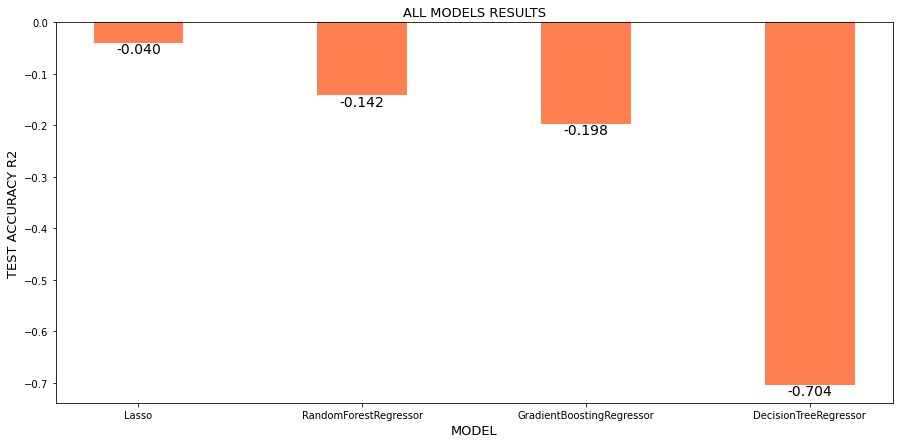

In [68]:
results = pd.read_csv(f"../results/ptd50_all_models_results.csv")
plt.figure(figsize=(15, 7))
plt.bar(results['Model'], results['test_accuracy_R2'], width = 0.4, color='coral')
plt.title(f"ALL MODELS RESULTS", fontsize=13)
plt.xlabel("MODEL", fontsize=13)
plt.ylabel("TEST ACCURACY R2", fontsize=13)
for i in range(len(results)):
     plt.text(i, results['test_accuracy_R2'][i] + -0.02, "{:.3f}".format(results['test_accuracy_R2'][i]), ha = 'center', fontsize=14)
plt.savefig(f'../results/ptd50_all_models_results_ptd50.jpg')
plt.show()